In [1]:
from time import sleep
import math
import random
# allows performing command-line operations from within Python
from subprocess import call, Popen

# tell jupyter notebook to show plots inline (with output)
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.stats.distributions import norm
import scipy.fftpack
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="statsmodels")

In [37]:
def GenEpochs(length, volatility):
    res = []
    state = random.randint(0,1)
    res.append(state)
    for i in range(1,length):
        if random.random() < volatility:
            state = 1 - state
        res.append(state)
    return res

GenEpochs(10,.1)

[0, 0, 0, 1, 1, 1, 1, 0, 0, 0]

In [776]:
# from Knuth
def PoissonSample(mean = 1):
    L = math.exp(-mean)
    k = 0
    p = 1
    while(p > L):
        k += 1
        p *= random.random()
    return k-1

In [777]:
def GenEpochsPois(N=16, mean=1):
    seq = []
    while (len(seq) < N):
        seq.extend([0]*PoissonSample(mean) + [1]*PoissonSample(mean))
    return seq[:N]

In [672]:
def AddNoise(seq, conf):
    res = seq.copy()
    for i in range(0,len(res)):
        if random.random() < conf:
            res[i] = 1 - res[i]
    return res
seq = GenEpochs(25,.1)
print(seq)
AddNoise(seq,0.2)

[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]


[1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]

In [654]:
def Entropy(dist):
    # return entropy in bits
    
    # shannon entropy
    listsum = sum(dist)
    entropy = 0
    for i in range(0,len(dist)):
        if dist[i] > 0:
            entropy += -dist[i]/listsum*math.log(dist[i]/listsum,2)
    return entropy

    # min entropy
#     return -math.log(max(dist)/listsum, 2);
    
    # collision entropy
#     listsum = sum(dist)
#     entropy = 0
#     for i in range(0,len(dist)):
#         if dist[i] > 0:
#             entropy += (dist[i]/listsum)**2
#     return -math.log(entropy, 2)

Entropy([.8,.2,0])

0.7219280948873623

In [107]:
def SameDiff(seq, delta):
    res = [0, 0]
    for i in range(0,len(seq)-delta):
        res[abs(seq[i+delta] - seq[i])] += 1
    return [x/(len(seq)-delta) for x in res]

SameDiff([0,0,0,0,1,1,1,1,1],1)

[0.875, 0.125]

In [109]:
Entropy(SameDiff(GenEpochs(10000000,.2),2))

0.8238731496614817

In [88]:
1-(1-0.28607532315578754)**2

0.49031155579288677

In [98]:
.53*.53

0.28090000000000004

In [99]:
.32/.53

0.6037735849056604

In [102]:
.1986/.32

0.620625

In [104]:
.1251/.1986

0.6299093655589123

In [110]:
1-.556

0.44399999999999995

In [111]:
1-.8238

0.17620000000000002

In [113]:
.444**2

0.197136

In [425]:
def GenAllSeqs(length):
    if length < 1:
        return [[]]
    res = [[0],[1]]
    for i in range(1,length):
        newres = []
        for j in range(0,len(res)):
            q = res[j].copy()
            q.append(0)
            newres.append(q)
            q = res[j]
            q.append(1)
            newres.append(q)
        res = newres
    return res

In [593]:
def CalcIdealState(seq, conf, vol):
    state = random.random()
    prob = 1
    for i in range(0, len(seq)):
        obs = seq[i]
        x = 1 - state
        if obs == 0:
            x *= (1 - conf)
            state *= conf
        if obs == 1:
            x *= conf
            state *= (1 - conf)
        prob *= x + state
        state /= x + state
        state = (1-vol)*state + vol*(1-state)
    return [state, prob]

CalcIdealState([0,1,0,1,0,1], .4, 1)

[0.6746300325709755, 0.005824844410046734]

In [926]:
def ScoreIdeal(seq, conf, vol, epochs = None):
    if epochs == None:
        epochs = seq
    state = 0.5
    correct = 0
    hist = []
    for obs, env in zip(seq, epochs):
        hist.append(state)
        if (env == 0 and state < 0.5) or (env == 1 and state >= 0.5):
            correct += 1
        x = 1 - state
        if obs == 0:
            x *= (1 - conf)
            state *= conf
        if obs == 1:
            x *= conf
            state *= (1 - conf)
        state /= x + state
        state = (1-vol)*state + vol*(1-state)
    return correct / len(seq)#, hist

In [621]:
seqs = GenAllSeqs(12)
states = []
probs = []
for seq in seqs:
    val = CalcIdealState(seq,.15,1/5)
    states.append(val[0])
    probs.append(val[1])

In [542]:
2**12

4096

In [522]:
states

[0.39146373857390965,
 0.5061375249884039,
 0.4430014037050175,
 0.5629831619258862,
 0.4139631484756378,
 0.5325046227254788,
 0.4707199227820664,
 0.5889104936496227,
 0.40117482081373784,
 0.5178399373055192,
 0.4556930703809559,
 0.575206871722454,
 0.4265199271595718,
 0.546139260724832,
 0.48388689878592134,
 0.6002849032575079,
 0.3956502926016931,
 0.5112449876093849,
 0.44862062212318576,
 0.5684718293766696,
 0.4196985568747279,
 0.5388226362377943,
 0.47691342446580137,
 0.5943315025768353,
 0.4066840890390765,
 0.5242580613756912,
 0.4623851794606878,
 0.5814087995231069,
 0.4326000375873272,
 0.5524867656309359,
 0.48977066906066524,
 0.6051885359507054,
 0.39328239766525924,
 0.5083680606680095,
 0.44547099298470044,
 0.5654106836892714,
 0.4165198287870506,
 0.5353401674840478,
 0.4735197225195077,
 0.5913769452719194,
 0.4037085512701169,
 0.5208109761609215,
 0.45881384640001,
 0.578119325110697,
 0.4293986332018792,
 0.5491646025962135,
 0.4867100539034219,
 0.6026511

In [523]:
probs

[0.005361095959885601,
 0.004830961722114401,
 0.0045798974431144005,
 0.004607903122885601,
 0.004475923629114401,
 0.004238492812885602,
 0.004252865029885601,
 0.004519040280114401,
 0.0044384561611144,
 0.0040873719048856,
 0.003975380809885599,
 0.0041024828761144,
 0.0041114237478856,
 0.003998509062114401,
 0.004126534719114401,
 0.0044955007188856,
 0.004438456161114401,
 0.004037415280885601,
 0.0038708874978856007,
 0.003938872812114401,
 0.003880567123885601,
 0.0037200623101144004,
 0.003782024655114401,
 0.004066454158885601,
 0.004073956279885599,
 0.003797431530114399,
 0.003744557187114399,
 0.0039153332508856,
 0.0039850934371144005,
 0.003925012876885601,
 0.004102995157885601,
 0.0045190402801144015,
 0.004475923629114401,
 0.004049904436885601,
 0.003858398341885601,
 0.0039014053441144008,
 0.0038135412798855997,
 0.0036311115301144,
 0.0036650421871144,
 0.0039153332508856,
 0.0038805671238856016,
 0.003593644062114401,
 0.0035175980311144012,
 0.00365242903088560

In [601]:
sum(probs)

0.9911192403418309

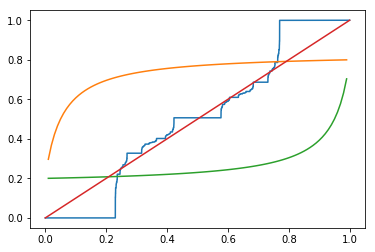

In [622]:
sortprobs = [x for _,x in sorted(zip(states,probs))]
sortstates = sorted(states)
cdfx = [0]
cdfy = [0]
for s, p in zip(sortstates,sortprobs):
    if s > cdfx[-1]:
        cdfx.append(s)
        cdfy.append(cdfy[-1])
    cdfx.append(s)
    cdfy.append(p + cdfy[-1])
cdfx.append(1)
cdfy.append(1)

plt.plot(cdfx, cdfy)

conf = .05
vol = 1/5

x1 = []
y1 = []
for s in [x/100 for x in range(1,100)]:
    x1.append(s)
    x = 1 - s
    obs = 1
    if obs == 0:
        x *= (1 - conf)
        s *= conf
    if obs == 1:
        x *= conf
        s *= (1 - conf)
    s /= x + s
    s = (1-vol)*s + vol*(1-s)
    y1.append(s)

plt.plot(x1, y1)
    
x0 = []
y0 = []
for s in [x/100 for x in range(1,100)]:
    x0.append(s)
    x = 1 - s
    obs = 0
    if obs == 0:
        x *= (1 - conf)
        s *= conf
    if obs == 1:
        x *= conf
        s *= (1 - conf)
    s /= x + s
    s = (1-vol)*s + vol*(1-s)
    y0.append(s)

plt.plot(x0, y0)

#yavg = [one * state + zero * (1-state) for state, one, zero in zip(x1,y1,y0)]
#plt.plot(x0, yavg)

plt.plot([0,1],[0,1])

In [465]:
sorted(states)

[0.31818181818181823,
 0.32608695652173914,
 0.34210526315789475,
 0.35714285714285715,
 0.39473684210526316,
 0.41489361702127653,
 0.44117647058823534,
 0.45652173913043476,
 0.5434782608695652,
 0.5588235294117647,
 0.5851063829787233,
 0.6052631578947368,
 0.6428571428571429,
 0.6578947368421051,
 0.6739130434782609,
 0.6818181818181819]

In [437]:
seqs

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

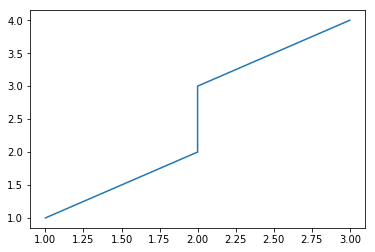

In [462]:
plt.plot([1,2,2,3],[1,2,3,4])

In [454]:
beta = 0.2
xs = len(seqs)
pxhat = [1/xs]*xs
pxh_x = [[1/xs for i in range(0,xs)] for i in range (0,xs)]
for iteration in range(0,1000):
    
    nxt_pxhat = [sum([probs[x]*pxh_x[x][xh] for x in range(0,xs)]) for xh in range(0,xs)]
    
    nxt_pxh_x = [[0 for i in range(0,xs)] for i in range (0,xs)]
    for x in range(0,xs):
        for xh in range(0,xs):
            nxt_pxh_x[x][xh] = pxhat[xh] * math.exp(-beta * abs(states[x]-states[xh]))
        total = sum(nxt_pxh_x[x])
        for xh in range(0,xs):
            nxt_pxh_x[x][xh] /= total

    pxhat = nxt_pxhat
    pxh_x = nxt_pxh_x


In [455]:
pxhat

[2.142408962229624e-06,
 0.16666595253034602,
 0.16666595253034602,
 0.16666595253034586,
 0.16666595253034602,
 0.16666595253034586,
 0.16666595253034586,
 2.142408962229625e-06]

In [443]:
pxh_x

[[0.13688711854930505,
  0.13114446359706114,
  0.13114446359706114,
  0.11866441783087568,
  0.13114446359706114,
  0.11866441783087568,
  0.11866441783087568,
  0.1136862371668845],
 [0.12707156604092704,
  0.132635873812671,
  0.132635873812671,
  0.12001390159960056,
  0.132635873812671,
  0.12001390159960056,
  0.12001390159960056,
  0.11497910772225833],
 [0.12707156604092704,
  0.132635873812671,
  0.132635873812671,
  0.12001390159960056,
  0.132635873812671,
  0.12001390159960056,
  0.12001390159960056,
  0.11497910772225833],
 [0.11497910772225833,
  0.12001390159960056,
  0.12001390159960056,
  0.132635873812671,
  0.12001390159960056,
  0.132635873812671,
  0.132635873812671,
  0.12707156604092704],
 [0.12707156604092704,
  0.132635873812671,
  0.132635873812671,
  0.12001390159960056,
  0.132635873812671,
  0.12001390159960056,
  0.12001390159960056,
  0.11497910772225833],
 [0.11497910772225833,
  0.12001390159960056,
  0.12001390159960056,
  0.132635873812671,
  0.120013

In [410]:
Entropy(probs)

1.7006474342919375

In [411]:
Entropy(pxhat)    

1.161312822161037

In [771]:
def ScoreMachine2(seq, trans, epochs = None):
    if epochs == None:
        epochs = seq
    state = random.randint(0,1)
    correct = 0
    for obs, env in zip(seq, epochs):
        if env == state:
            correct += 1
        if random.random() > trans[state][obs]:
            state = 1 - state
    return correct / len(seq)
ScoreMachine2([0,1,0],[[1,1],[1,1]])

0.6666666666666666

In [773]:
n = 100000
conf = .35
vol = 1/25
epochs = GenEpochs(n, vol)
seq = AddNoise(epochs, conf)
print(ScoreMachine2(seq, [[1,0],[.1,.9]], epochs))
print(ScoreMachine2(seq, [[1,0],[0,1]], epochs))

0.62422
0.63731


In [891]:
def ScoreMachine3(seq, trans, epochs = None):
    if epochs == None:
        epochs = seq
    state = random.randint(0,2)
    correct = 0
    hist = []
    for obs, env in zip(seq, epochs):
        hist.append(state)
        if (env == 0 and state == 0) or (env > 0 and state > 0):
            correct += 1
        curtrans = trans[state][obs]
        rand = random.random()
        state = 0
        if rand > curtrans[0]:
            state = 1
        if rand > curtrans[0] + curtrans[1]:
            state = 2
    return correct / len(seq)#, hist
table = [
    [
        [1,0,0],
        [0,1,0]
    ],
    [
        [0,1,0],
        [0,0,1]
    ],
    [
        [1,0,0],
        [0,1,0]
    ]
]
ScoreMachine3([1,0,0],table)

0.3333333333333333

In [984]:
def ScoreMachine4(seq, trans, epochs = None):
    if epochs == None:
        epochs = seq
    state = random.randint(0,3)
    correct = 0
    hist = []
    for obs, env in zip(seq, epochs):
        hist.append(state)
        if (env == 0 and state <= 1) or (env > 0 and state >= 2):
            correct += 1
        curtrans = trans[state][obs]
        rand = random.random()
        state = 0
        if rand > curtrans[0]:
            state = 1
        if rand > curtrans[0] + curtrans[1]:
            state = 2
        if rand > curtrans[0] + curtrans[1] + curtrans[2]:
            state = 3
    return correct / len(seq)#, hist
table = [
    [
        [1,0,0,0],
        [0,1,0,0]
    ],
    [
        [1,0,0,0],
        [0,0,1,0]
    ],
    [
        [0,1,0,0],
        [0,0,0,1]
    ],
    [
        [0,0,1,0],
        [0,0,0,1]
    ]
]
ScoreMachine4([1,0,0],table)

0.3333333333333333

In [865]:
n = 100000
conf = .1
vol = 1/5
#epochs = GenEpochsPois(n, 1/vol)
epochs = GenEpochs(n, vol)
seq = AddNoise(epochs, conf)

table = [
    [
        [1,0,0],
        [0,1,0]
    ],
    [
        [1,0,0],
        [0,1,0]
    ],
    [
        [1,0,0],
        [0,1,0]
    ]
]
print(ScoreMachine3(seq,table,epochs))

table = [
    [
        [1,0,0],
        [0,0,1]
    ],
    [
        [0,0,1],
        [0,1,0]
    ],
    [
        [1,0,0],
        [0,1,0]
    ]
]
print(ScoreMachine3(seq,table,epochs))

0.73993
0.70954


In [839]:
def All3sTables():
    res = []
    for a in range(0,3):
        for b in range(0,3):
            for c in range(0,3):
                for d in range(0,3):
                    for e in range(0,3):
                        for f in range(0,3):
                            table = [
                                [
                                    [0,0,0],
                                    [0,0,0]
                                ],
                                [
                                    [0,0,0],
                                    [0,0,0]
                                ],
                                [
                                    [0,0,0],
                                    [0,0,0]
                                ]
                            ]
                            table[0][0][a] = 1
                            table[0][1][b] = 1
                            table[1][0][c] = 1
                            table[1][1][d] = 1
                            table[2][0][e] = 1
                            table[2][1][f] = 1
                            res.append(table)
    return res

[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]], [[0, 1, 0], [1, 0, 0]]]

In [998]:
def All4sTables():
    res = []
    for a in range(0,4):
        for b in range(0,4):
            for c in range(0,4):
                for d in range(0,4):
                    for e in range(0,4):
                        for f in range(0,4):
                            for g in range(0,4):
                                for h in range(0,4):
                                    table = [
                                        [
                                            [0,0,0,0],
                                            [0,0,0,0]
                                        ],
                                        [
                                            [0,0,0,0],
                                            [0,0,0,0]
                                        ],
                                        [
                                            [0,0,0,0],
                                            [0,0,0,0]
                                        ],
                                        [
                                            [0,0,0,0],
                                            [0,0,0,0]
                                        ]
                                    ]
                                    table[0][0][a] = 1
                                    table[0][1][b] = 1
                                    table[1][0][c] = 1
                                    table[1][1][d] = 1
                                    table[2][0][e] = 1
                                    table[2][1][f] = 1
                                    table[3][0][g] = 1
                                    table[3][1][h] = 1
                                    res.append(table)
    return res

All4sTables()[100]

[[[1, 0, 0, 0], [1, 0, 0, 0]],
 [[1, 0, 0, 0], [1, 0, 0, 0]],
 [[0, 1, 0, 0], [0, 0, 1, 0]],
 [[0, 1, 0, 0], [1, 0, 0, 0]]]

In [1224]:
def PFSM4s():
    res = []
    for a in range(0,33):
        for b in range(0,33):
            for c in range(0,33):
                table = [
                    [
                        [1,0,0,0],
                        [0,a/32,1-a/32,0]
                    ],
                    [
                        [b/32,1-b/32,0,0],
                        [0,c/32,1-c/32,0]
                    ],
                    [
                        [0,1-c/32,c/32,0],
                        [0,0,1-b/32,b/32]
                    ],
                    [
                        [0,1-a/32,a/32,0],
                        [0,0,0,1]
                    ]
                ]
                res.append(table)
    return res

PFSM4s()[100]

[[[1, 0, 0, 0], [0, 0.0, 1.0, 0]],
 [[0.09375, 0.90625, 0, 0], [0, 0.03125, 0.96875, 0]],
 [[0, 0.96875, 0.03125, 0], [0, 0, 0.90625, 0.09375]],
 [[0, 1.0, 0.0, 0], [0, 0, 0, 1]]]

In [1010]:
len(AllBetter4s)/len(AllGood4s)

0.8848920863309353

In [963]:
n = 100000
conf = .1
vol = 1/15
#epochs = GenEpochsPois(n, 1/vol)
epochs = GenEpochs(n, vol)
seq = AddNoise(epochs, conf)

besttable = None
bestscore = -1
for table in All3sTables():
    score = ScoreMachine3(seq,table,epochs)
    if score > bestscore:
        bestscore = score
        besttable = table
        print(bestscore)
        print(besttable)

0.48928
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]]]
0.48929
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]], [[0, 1, 0], [0, 0, 1]]]
0.51071
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [0, 1, 0]], [[0, 0, 1], [0, 0, 1]]]
0.66909
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]]]
0.6691
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [0, 1, 0]]]
0.84935
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [1, 0, 0]]]
0.84936
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 1, 0]], [[0, 1, 0], [0, 0, 1]]]
0.85159
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 0, 1]], [[0, 1, 0], [0, 1, 0]]]
0.85522
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 0, 1]], [[0, 1, 0], [0, 0, 1]]]
0.85523
[[[1, 0, 0], [0, 0, 1]], [[0, 0, 1], [0, 1, 0]], [[1, 0, 0], [0, 1, 0]]]


In [1043]:

conf = .15
vol = 1/10
#epochs = GenEpochsPois(n, 1/vol)


tables = All4sTables()
scores4s = [1]*len(tables)

for r in range(0,4):
    n = 100 * (r**2+1)
    epochs = GenEpochs(n, vol)
    seq = AddNoise(epochs, conf)
    epochsV = GenEpochs(n, 1-vol)
    seqV = AddNoise(epochsV, conf)
    besttable = None
    bestscore = -1
    for i in range(0,len(tables)):
        oldscore = scores4s[i]
        if oldscore > 0.50 + r * 0.05:
            table = tables[i]
            score = (ScoreMachine4(seq,table,epochs)+ScoreMachine4(seqV,table,epochsV))/2

            scores4s[i] = score

            if score > bestscore:
                bestscore = score
                besttable = table
                print(bestscore)
                print(besttable)
    print()

0.59
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]]]
0.5900000000000001
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]]]
0.595
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 0, 1, 0], [0, 0, 0, 1]]]
0.6
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 0, 1]], [[0, 0, 1, 0], [1, 0, 0, 0]]]
0.615
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]]]
0.62
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]]]
0.635
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[1, 0, 0, 0], [0, 1, 0, 0]]]
0.645
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 

In [1175]:
# 3 states, 2 sided

conf = .4
vol = .05
#epochs = GenEpochsPois(n, 1/vol)


tables = All3sTables()
scores3s = [1]*len(tables)

for r in range(0,10):
    n = 10000 * (r**2+1)
    epochs = GenEpochs(n, vol)
    seq = AddNoise(epochs, conf)
    epochsV = GenEpochs(n, 1-vol)
    seqV = AddNoise(epochsV, conf)
    besttable = None
    bestscore = -1
    for i in range(0,len(tables)):
        oldscore = scores3s[i]
        if oldscore > 0.50 + r * 0.02:
            table = tables[i]
            score = (ScoreMachine3(seq,table,epochs)*1.8+ScoreMachine3(seqV,table,epochsV))/2.8

            scores3s[i] = score

            if score > bestscore:
                bestscore = score
                besttable = table
                print(bestscore)
                print(besttable)
    print()

0.47801428571428567
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]]]
0.4783357142857143
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [0, 0, 1]]]
0.47840000000000005
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]], [[0, 1, 0], [0, 0, 1]]]
0.5226928571428572
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [0, 1, 0]], [[0, 0, 1], [0, 0, 1]]]
0.5306214285714286
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [1, 0, 0]]]
0.5495214285714286
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 0, 1]], [[0, 1, 0], [0, 1, 0]]]
0.5706642857142857
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 0, 1]], [[0, 1, 0], [0, 0, 1]]]

0.5009464285714286
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [0, 1, 0]], [[0, 0, 1], [0, 0, 1]]]
0.5010107142857142
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [0, 0, 1]], [[0, 0, 1], [0, 0, 1]]]
0.5289571428571429
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [1, 0, 0]]]
0.5289750000000001
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 1, 0]], [[0, 1, 0

In [1166]:
# 4 states, 2 sided

conf = .25
vol = .3
#epochs = GenEpochsPois(n, 1/vol)


tables = All4sTables()
scores4s = [1]*len(tables)

for r in range(0,10):
    n = 100 * (r**2+1)
    print(n)
    print()
    epochs = GenEpochs(n, .3)
    seq = AddNoise(epochs, conf)
    epochsV = GenEpochs(n, .1)
    seqV = AddNoise(epochsV, conf)
    besttable = None
    bestscore = -1
    for i in range(0,len(tables)):
        oldscore = scores4s[i]
        if oldscore > 0.50 + r * 0.03:
            table = tables[i]
            score = (ScoreMachine4(seq,table,epochs)+ScoreMachine4(seqV,table,epochsV))/2

            scores4s[i] = score

            if score > bestscore:
                bestscore = score
                besttable = table
                print(bestscore)
                print(besttable)
    print()

100

0.5700000000000001
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]]]
0.575
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [0, 1, 0, 0]]]
0.5900000000000001
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [0, 0, 0, 1]]]
0.61
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 0, 1]], [[0, 0, 0, 1], [0, 0, 1, 0]]]
0.625
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]]]
0.6799999999999999
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]]]
0.69
[[[1, 0, 0, 0], [0, 1, 0, 0]], [[1, 0, 0, 0], [0, 0, 1, 0]], [[0, 0, 0, 1], [0, 1, 0, 0]], [[0, 1, 0, 0], [0, 0, 0, 1]]]
0.6950000000000001
[[[1, 0, 0, 0], [0, 1, 0, 0]], [[1, 0, 0, 0], [0, 

In [1072]:
# 3 states, 5 poissoins

#epochs = GenEpochsPois(n, 1/vol)


tables = All3sTables()
scores3s = [1]*len(tables)

for r in range(0,4):
    n = 10000 * (r**2+1)
    epochsA = GenEpochsPois(n, 15)
    seqA = AddNoise(epochsA, .25)
    epochsB = GenEpochsPois(n, 35)
    seqB = AddNoise(epochsB, .25)
    epochsC = GenEpochsPois(n, 25)
    seqC = AddNoise(epochsC, .25)
    epochsD = GenEpochsPois(n, 25)
    seqD = AddNoise(epochsD, .15)
    epochsE = GenEpochsPois(n, 25)
    seqE = AddNoise(epochsE, .35)
    besttable = None
    bestscore = -1
    for i in range(0,len(tables)):
        oldscore = scores3s[i]
        if oldscore > 0.50 + r * 0.05:
            table = tables[i]
            score = ScoreMachine3(seqA,table,epochsA) + ScoreMachine3(seqB,table,epochsB) + ScoreMachine3(seqC,table,epochsC) + ScoreMachine3(seqD,table,epochsD) + ScoreMachine3(seqE,table,epochsE)
            score /= 5
            scores3s[i] = score

            if score > bestscore:
                bestscore = score
                besttable = table
                print(bestscore)
                print(besttable)
    print()

0.49922000000000005
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]]]
0.49924
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [0, 1, 0]]]
0.49928
[[[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]], [[0, 1, 0], [1, 0, 0]]]
0.5002599999999999
[[[1, 0, 0], [1, 0, 0]], [[0, 1, 0], [1, 0, 0]], [[0, 0, 1], [0, 0, 1]]]
0.5029399999999999
[[[1, 0, 0], [1, 0, 0]], [[0, 1, 0], [0, 1, 0]], [[0, 1, 0], [0, 1, 0]]]
0.6077600000000001
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [1, 0, 0]], [[1, 0, 0], [1, 0, 0]]]
0.60778
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [1, 0, 0]], [[0, 1, 0], [1, 0, 0]]]
0.6077999999999999
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [1, 0, 0]], [[0, 0, 1], [1, 0, 0]]]
0.72862
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [1, 0, 0]]]
0.72866
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 1, 0]], [[0, 0, 1], [1, 0, 0]]]
0.7396800000000001
[[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 0, 1]], [[0, 1, 0], [0, 1, 0]]]
0.7568400000000001
[[[1, 0, 0], [0, 1, 0]]

In [1089]:
# 4 states, 5 poissoins

#epochs = GenEpochsPois(n, 1/vol)


tables = All4sTables()
scores4s = [1]*len(tables)

for r in range(0,4):
    n = 100 * (r**2+1)
    epochsA = GenEpochsPois(n, 15)
    seqA = AddNoise(epochsA, .25)
    epochsB = GenEpochsPois(n, 35)
    seqB = AddNoise(epochsB, .25)
    epochsC = GenEpochsPois(n, 25)
    seqC = AddNoise(epochsC, .25)
    epochsD = GenEpochsPois(n, 25)
    seqD = AddNoise(epochsD, .15)
    epochsE = GenEpochsPois(n, 25)
    seqE = AddNoise(epochsE, .35)
    besttable = None
    bestscore = -1
    for i in range(0,len(tables)):
        oldscore = scores4s[i]
        if oldscore > 0.50 + r * 0.05:
            table = tables[i]
            score = ScoreMachine4(seqA,table,epochsA) + ScoreMachine4(seqB,table,epochsB) + ScoreMachine4(seqC,table,epochsC) + ScoreMachine4(seqD,table,epochsD) + ScoreMachine4(seqE,table,epochsE)
            score /= 5
            scores4s[i] = score

            if score > bestscore:
                bestscore = score
                besttable = table
                print(bestscore)
                print(besttable)
    print()

0.5740000000000001
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]]]
0.5760000000000001
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [0, 0, 0, 1]]]
0.5780000000000001
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [0, 0, 0, 1]], [[0, 0, 1, 0], [1, 0, 0, 0]]]
0.612
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]], [[1, 0, 0, 0], [1, 0, 0, 0]]]
0.618
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]], [[1, 0, 0, 0], [0, 1, 0, 0]]]
0.648
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]], [[1, 0, 0, 0], [0, 0, 0, 1]]]
0.66
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]], [[0, 1, 0, 0], [0, 1, 0, 0]]]
0.666
[[[1, 0, 0, 0], [1, 0, 0, 0]], [[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1

In [1263]:
# 4 states, 2 poissoins

#epochs = GenEpochsPois(n, 1/vol)


#tables = All4sTables()
tables = PFSM4s()
#scores4s = [1]*len(tables)

for r in range(6,15):
    n = 100 * (r**2+1)
    print(n)
    print()
    
    epochsA = GenEpochsPois(n, 3)
    seqA = AddNoise(epochsA, .15)
    
    #epochsB = GenEpochsPois(n, 30)
    #seqB = AddNoise(epochsB, .25)
    
    besttable = None
    bestscore = -1
    count = 0
    for i in range(0,len(tables)):
        oldscore = scores4s[i]
        if oldscore > 0.60 + r * 0.005:
            count += 1
            table = tables[i]
            score = ScoreMachine4(seqA,table,epochsA)# + ScoreMachine4(seqB,table,epochsB)
            #score /= 2
            scores4s[i] = score

            if score > bestscore:
                bestscore = score
                besttable = table
                print(bestscore)
                print(besttable)
    print(count)
    print()

3700

0.6394594594594595
[[[1, 0, 0, 0], [0, 0.0, 1.0, 0]], [[0.0, 1.0, 0, 0], [0, 0.0, 1.0, 0]], [[0, 1.0, 0.0, 0], [0, 0, 1.0, 0.0]], [[0, 1.0, 0.0, 0], [0, 0, 0, 1]]]
0.6397297297297297
[[[1, 0, 0, 0], [0, 0.0, 1.0, 0]], [[0.125, 0.875, 0, 0], [0, 0.0, 1.0, 0]], [[0, 1.0, 0.0, 0], [0, 0, 0.875, 0.125]], [[0, 1.0, 0.0, 0], [0, 0, 0, 1]]]
0.64
[[[1, 0, 0, 0], [0, 0.0, 1.0, 0]], [[0.25, 0.75, 0, 0], [0, 0.03125, 0.96875, 0]], [[0, 0.96875, 0.03125, 0], [0, 0, 0.75, 0.25]], [[0, 1.0, 0.0, 0], [0, 0, 0, 1]]]
0.6405405405405405
[[[1, 0, 0, 0], [0, 0.0, 1.0, 0]], [[0.46875, 0.53125, 0, 0], [0, 0.0625, 0.9375, 0]], [[0, 0.9375, 0.0625, 0], [0, 0, 0.53125, 0.46875]], [[0, 1.0, 0.0, 0], [0, 0, 0, 1]]]
859

5000

0.6422
[[[1, 0, 0, 0], [0, 0.0, 1.0, 0]], [[0.0, 1.0, 0, 0], [0, 0.0, 1.0, 0]], [[0, 1.0, 0.0, 0], [0, 0, 1.0, 0.0]], [[0, 1.0, 0.0, 0], [0, 0, 0, 1]]]
0.6424
[[[1, 0, 0, 0], [0, 0.0, 1.0, 0]], [[0.03125, 0.96875, 0, 0], [0, 0.0, 1.0, 0]], [[0, 1.0, 0.0, 0], [0, 0, 0.96875, 0.03125]],

In [1041]:
count = 0
for score in scores4s:
    if score > 0.6:
        count += 1
count / len(scores4s)

0.012298583984375

In [1014]:
len(AllGood4s)/len(All4sTables())

0.0001983642578125

In [1266]:
n = 40000
#conf = .25
vol = 1/25

# table0 = [
#     [
#         [1,0,0],
#         [0,1,0]
#     ],
#     [
#         [1,0,0],
#         [0,0,1]
#     ],
#     [
#         [0,1,0],
#         [0,0,1]
#     ]
# ]

table0 = [
    [
        [0,1,0],
        [0,0,1]
    ],
    [
        [1,0,0],
        [1,0,0]
    ],
    [
        [0,1,0],
        [0,0,1]
    ]
]


table1 = [
    [
        [1,0,0],
        [0,1,0]
    ],
    [
        [1,0,0],
        [0,0,1]
    ],
    [
        [1,0,0],
        [0,0,1]
    ]
]

table5 = [[[1, 0, 0], [0, 1, 0]], [[1, 0, 0], [0, 0, 1]], [[0, 1, 0], [0, 1, 0]]] 

# table2 = [
#     [
#         [1,0,0,0],
#         [0,1,0,0]
#     ],
#     [
#         [1,0,0,0],
#         [0,0,1,0]
#     ],
#     [
#         [0,1,0,0],
#         [0,0,0,1]
#     ],
#     [
#         [0,0,1,0],
#         [0,0,0,1]
#     ]
# ]

table2 = [[[0, 1, 0, 0], [0, 0, 1, 0]], [[0, 1, 0, 0], [1, 0, 0, 0]], [[1, 0, 0, 0], [0, 0, 0, 1]], [[0, 0, 1, 0], [0, 0, 0, 1]]]
# table4 = [
#     [
#         [0,0,1,0],
#         [0,0,0,1]
#     ],
#     [
#         [0,1,0,0],
#         [1,0,0,0]
#     ],
#     [
#         [0,1,0,0],
#         [1,0,0,0]
#     ],
#     [
#         [0,0,1,0],
#         [0,0,0,1]
#     ]
# ]

#table4 = [[[1, 0, 0, 0], [0, 0.875, 0.125, 0]], [[0.46875, 0.53125, 0, 0], [0, 0.0, 1.0, 0]], [[0, 1.0, 0.0, 0], [0, 0, 0.53125, 0.46875]], [[0, 0.125, 0.875, 0], [0, 0, 0, 1]]]
table4 = [[[1, 0, 0, 0], [0, 0.0, 1.0, 0]], [[0.71875, 0.28125, 0, 0], [0, 0.03125, 0.96875, 0]], [[0, 0.96875, 0.03125, 0], [0, 0, 0.28125, 0.71875]], [[0, 1.0, 0.0, 0], [0, 0, 0, 1]]]
# table4 = [
#     [
#         [1,0,0,0],
#         [0,1,0,0]
#     ],
#     [
#         [.5,.5,0,0],
#         [0,0,1,0]
#     ],
#     [
#         [0,1,0,0],
#         [0,0,.5,.5]
#     ],
#     [
#         [0,0,1,0],
#         [0,0,0,1]
#     ]
# ]

vols = []
picks = []
confs = []
scores = [[],[],[],[],[],[]]
for conf in [x/60 for x in range(1,60)]:
    #epochs = GenEpochs(n, vol)
    epochs = GenEpochsPois(n, 1/vol)
    seq = AddNoise(epochs, conf)
    score0 = ScoreMachine3(seq,table0,epochs)
    score1 = ScoreMachine3(seq,table1,epochs)
    score2 = ScoreMachine4(seq,table2,epochs)
    score3 = ScoreIdeal(seq,conf,vol,epochs)
    score4 = ScoreMachine4(seq,table4,epochs)
    score5 = ScoreMachine3(seq,table5,epochs)
    pick = 0
    if score1 > score0:
        pick = 1
    elif score1 == score0:
        pick = 0.5
    picks.append(pick)
    vols.append(1/vol)
    confs.append(conf)
    scores[0].append(score0)
    scores[1].append(score1)
    scores[2].append(score2)
    scores[3].append(score3)
    scores[4].append(score4)
    scores[5].append(score5)

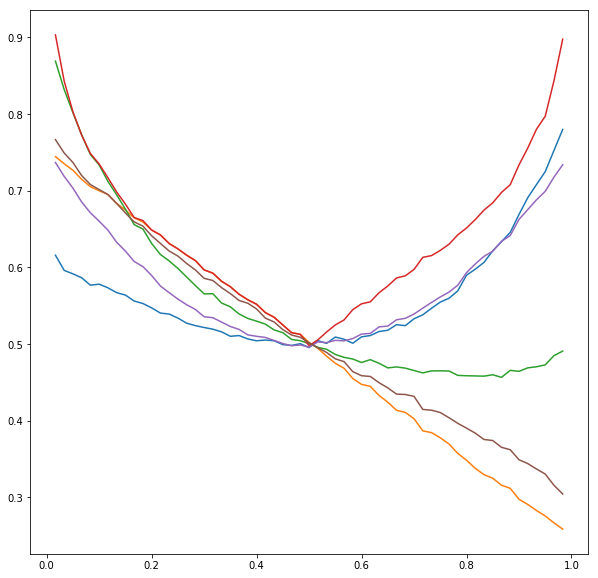

In [1185]:
# blue orange green red purple brown

plt.figure(figsize=(10,10))

#plt.plot(vols,picks)
plt.plot(vols,scores[0])
plt.plot(vols,scores[1])
plt.plot(vols,scores[2])
plt.plot(vols,scores[3])
plt.plot(vols,scores[4])
plt.plot(vols,scores[5])

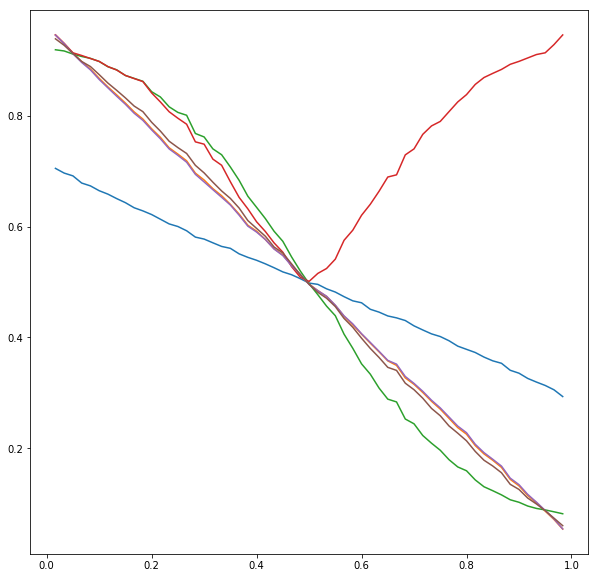

In [1267]:
# blue orange green red purple brown

plt.figure(figsize=(10,10))

#plt.plot(vols,picks)
plt.plot(confs,scores[0])
plt.plot(confs,scores[1])
plt.plot(confs,scores[2])
plt.plot(confs,scores[3])
plt.plot(confs,scores[4])
plt.plot(confs,scores[5])

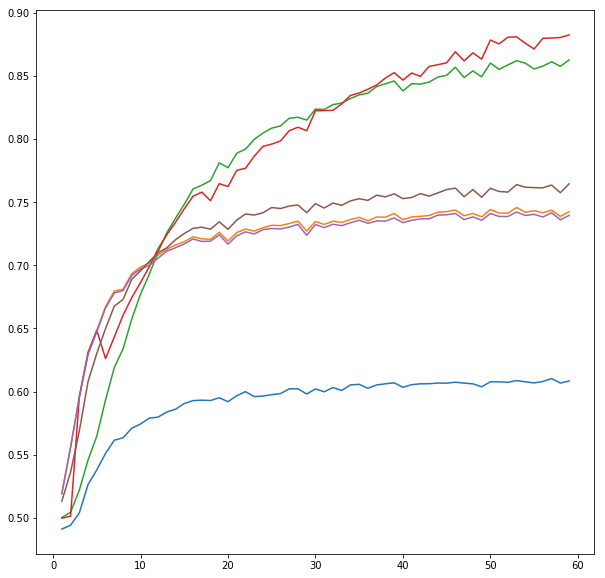

In [1265]:
# blue orange green red purple brown

plt.figure(figsize=(10,10))

#plt.plot(vols,picks)
plt.plot(vols,scores[0])
plt.plot(vols,scores[1])
plt.plot(vols,scores[2])
plt.plot(vols,scores[3]) # ideal assming constant hazard rate
plt.plot(vols,scores[4])
plt.plot(vols,scores[5])

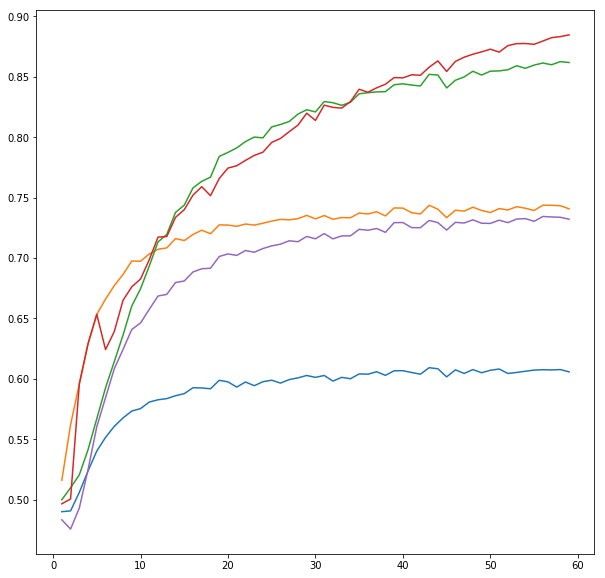

In [1207]:
plt.figure(figsize=(10,10))
#plt.plot(vols,picks)
plt.plot(vols,scores[0])
plt.plot(vols,scores[1])
plt.plot(vols,scores[2])
plt.plot(vols,scores[3])
plt.plot(vols,scores[4])

In [ ]:
# 100  100
# 010  001
# 100  001
# 001  010
# 010  100
# 001  010
#    2    3
#
# 010  001
# 001  010
# 100  001
# 100  010
# 010  100
# 001  100
#    5    4
#
# 100  100
# 010  010
# 100  100
# 001  010
# 100  100
# 001  010
#    1    1
#
# 100  100
# 010  001
# 100  001
# 001  001
# 010  100
# 010  010
#    1    2
#
# __0
# 0__
# 100
# _0_
# __0
# 0__
#
#
# 1._
# _1.
# 1__
# ._1
# .1_
# _.1

In [1246]:
def PFSM3s():
    res = []
    for a in range(0,6):
        for b in range(0,6):
            for c in range(0,6):
                for d in range(0,6):
                    for e in range(0,6):
                        for f in range(0,6):
                            table = [
                                [
                                    [a/5,1-a/5,0],
                                    [0,b/5,1-b/5]
                                ],
                                [
                                    [c/5,0,1-c/5],
                                    [d/5,0,1-d/5]
                                ],
                                [
                                    [e/5,1-e/5,0],
                                    [0,f/5,1-f/5]
                                ]
                            ]
                            res.append(table)
    return res

PFSM3s()[100]

[[[0.0, 1.0, 0], [0, 0.0, 1.0]],
 [[0.0, 0, 1.0], [0.4, 0, 0.6]],
 [[0.8, 0.19999999999999996, 0], [0, 0.8, 0.19999999999999996]]]

In [1251]:
# 3 states, 2 sided

conf = .35
vol = .15
#epochs = GenEpochsPois(n, 1/vol)


tables = PFSM3s()
scores3s = [1]*len(tables)

for r in range(0,15):
    n = 100 * (r**2+1)
    print(n)
    print()
    epochs = GenEpochs(n, .1)
    seq = AddNoise(epochs, .25)
    epochsV = GenEpochs(n, .6)
    seqV = AddNoise(epochsV, .25)
    besttable = None
    bestscore = -1
    count = 0
    for i in range(0,len(tables)):
        oldscore = scores3s[i]
        if oldscore > 0.50 + r * 0.03:
            count += 1
            table = tables[i]
            score = (ScoreMachine3(seq,table,epochs)*1.0+ScoreMachine3(seqV,table,epochsV))/2.0

            scores3s[i] = score

            if score > bestscore:
                bestscore = score
                besttable = table
                print(bestscore)
                print(besttable)
    print(count)
    print()

100

0.415
[[[0.0, 1.0, 0], [0, 0.0, 1.0]], [[0.0, 0, 1.0], [0.0, 0, 1.0]], [[0.0, 1.0, 0], [0, 0.0, 1.0]]]
0.45999999999999996
[[[0.0, 1.0, 0], [0, 0.0, 1.0]], [[0.0, 0, 1.0], [0.0, 0, 1.0]], [[0.2, 0.8, 0], [0, 0.2, 0.8]]]
0.47
[[[0.0, 1.0, 0], [0, 0.0, 1.0]], [[0.0, 0, 1.0], [0.0, 0, 1.0]], [[0.8, 0.19999999999999996, 0], [0, 0.2, 0.8]]]
0.49
[[[0.0, 1.0, 0], [0, 0.0, 1.0]], [[0.0, 0, 1.0], [0.0, 0, 1.0]], [[0.8, 0.19999999999999996, 0], [0, 0.6, 0.4]]]
0.505
[[[0.0, 1.0, 0], [0, 0.0, 1.0]], [[0.0, 0, 1.0], [0.4, 0, 0.6]], [[0.8, 0.19999999999999996, 0], [0, 0.4, 0.6]]]
0.51
[[[0.0, 1.0, 0], [0, 0.0, 1.0]], [[0.0, 0, 1.0], [0.6, 0, 0.4]], [[0.8, 0.19999999999999996, 0], [0, 1.0, 0.0]]]
0.515
[[[0.0, 1.0, 0], [0, 0.0, 1.0]], [[0.0, 0, 1.0], [1.0, 0, 0.0]], [[0.4, 0.6, 0], [0, 0.4, 0.6]]]
0.52
[[[0.0, 1.0, 0], [0, 0.0, 1.0]], [[0.2, 0, 0.8], [0.8, 0, 0.19999999999999996]], [[0.4, 0.6, 0], [0, 0.6, 0.4]]]
0.525
[[[0.0, 1.0, 0], [0, 0.0, 1.0]], [[0.2, 0, 0.8], [1.0, 0, 0.0]], [[1.0, 0.0

In [ ]:
0.7859
[[[1.0, 0.0, 0], [0, 0.0, 1.0]], [[0.8, 0, 0.19999999999999996], [0.8, 0, 0.19999999999999996]], [[1.0, 0.0, 0], [0, 0.0, 1.0]]]

